# Updated experiments for the ROC curve with different prompt, a higher temperature and extraction of the best threshold

In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
from sklearn import preprocessing
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, calculate_all_clusters, show_all_clusters, calculate_roc_curve, plot_roc_curve, find_best_threshold

2025-03-02 13:08:00.947913: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 13:08:00.988229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-02 13:08:00.988271: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-02 13:08:00.988294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 13:08:01.004060: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def run_experiment_different_prompts(path_to_experiments, prompt_starts, runs_per_task, temperature, epsilon, min_samples):
    tasks, images, ground_truths, objects = extract_all(path_to_experiments)
    prompt_end = " Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the relevant object. Dont output anything else."
    softmax_fn = torch.nn.Softmax(dim=-1)
    labels = []

    coordinates = [[],[]]

    distances = [[],[]]
    
    spreads = [[],[]]

    diameters = [[],[]]

    majority_size_rates = [[],[]]


    #probs = [[],[]]
    
    for i in range(len(tasks)):
        prompts = []
        task = tasks[i]
        labels.append(task)
        ground_truth = ground_truths[i]

        objects_of_task = objects[i]
        prompts_what = []
        for prompt_start in prompt_starts:
            prompt = prompt_start + task + "For that you have to point to the object in the picture that has to be moved." + prompt_end
            prompts_what.append(prompt)

        prompts.append(prompts_what)


        print(f"{task}")
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            if (len(ground_truth) == 2):
                prompts_where = []
                for prompt_start in prompt_starts:
                    prompt = prompt_start + task + "For that you have to point to the place in the picture where the object has to be moved to." +  prompt_end
                    prompts_where.append(prompt)
                labels.append(task)
                prompts.append(prompts_where)
    
            for k in range(len(prompts)):
                task_coordinates = []
                task_distances = []
                #probabilities = []

                for prompt in prompts[k]:
                    for j in range(runs_per_task):
                        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)                    
                        coords = get_coordinates(output_text, image_width, image_height)
                        if(coords[0] < 0 or coords[0] < 0):
                            continue
                        
                        norm_dist = calculate_normalized_euclidian_distance(coords, ground_truth[k], image_width, image_height)
                        task_coordinates.append(coords)
                        task_distances.append(norm_dist)
                        #probabilities.append(calculate_probability_of_coordinates(output, inputs, processor))
                    coordinates[k].append(task_coordinates)
                            
                n_clusters, index_majority_cluster, cluster_points, noisy_points, centroids, diameters_of_clusters = calculate_all_clusters(task_coordinates, epsilon=epsilon, min_samples=min_samples)
                if (n_clusters != 0):
                    norm_dist = calculate_normalized_euclidian_distance(centroids[index_majority_cluster], ground_truth[k], image_width, image_height)
                    distances[k].append(norm_dist)
                    spreads[k].append(calculate_spread(task_coordinates, image_width, image_height))
                    diameters[k].append(diameters_of_clusters[index_majority_cluster])
                    majority_size_rates[k].append(len(cluster_points[index_majority_cluster]) / len(task_coordinates))
                    #probs[k].append(np.mean(probabilities))
                    #show_all_clusters(image, index_majority_cluster, cluster_points, noisy_points, centroids, diameters_of_clusters)
                #else:
                    #visualize_points_on_image(image, ["predictions"], [task_coordinates], "")
                    

                #print("")

    return coordinates, distances, spreads, diameters, majority_size_rates#, probs


In [ ]:
experiment_path = "../data/base_experiments"
num_runs = 6
temperature = 1

epsilon = 20
min_samples = 3

prompt_starts = [
    "You are the robot in the picture. Your mission it to guide and support the user in its task to: ",
    "Your mission it to guide and support the user in its task to: ",
    "You are the robot in the picture. You have to: ",
    "You are the robot. Your mission is to: ",
    "You are the robot in the picture. Your task is to: "
    ]

#prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
#prompt_ends = [, "  Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

coordinates, distances, spreads, diameters, majority_size_rates = run_experiment_different_prompts(experiment_path, prompt_starts, num_runs, temperature, epsilon, min_samples)

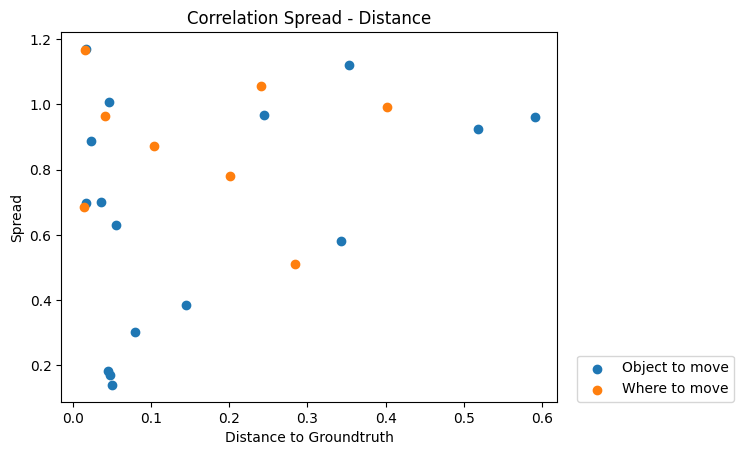

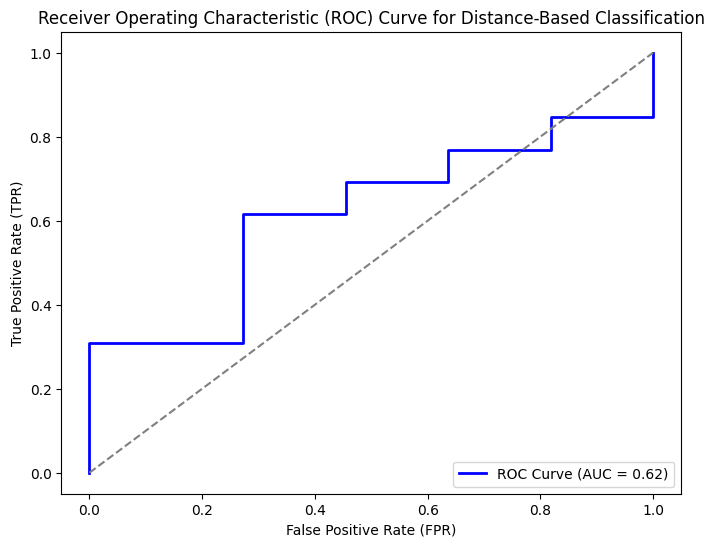

0.30002615841286606


In [5]:
spreads_0 = [1 - spread for spread in spreads[0]]
spreads_1 = [1 - spread for spread in spreads[1]]
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0] + distances[1], 0.1, spreads_0 + spreads_1)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)

plot_scatter(["Object to move", "Where to move"], spreads, distances, "Correlation Spread - Distance", "Distance to Groundtruth", "Spread")
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds[best_idx])

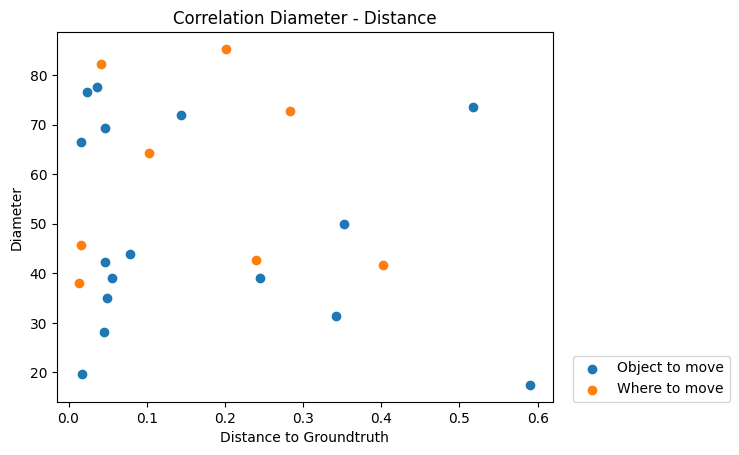

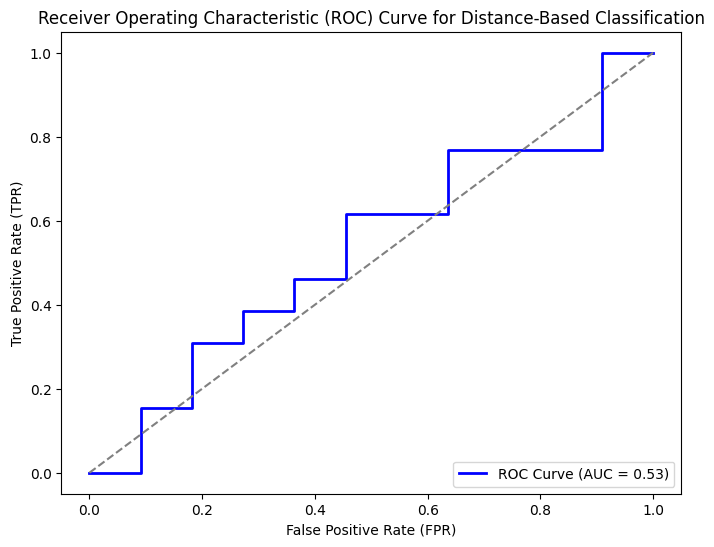

0.8329645241345985


In [6]:
dias = preprocessing.normalize([diameters[0] + diameters[1]])
dias = [1 - diameter for diameter in dias[0]]
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0] + distances[1], 0.1, dias)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)

plot_scatter(["Object to move", "Where to move"], diameters, distances, "Correlation Diameter - Distance", "Distance to Groundtruth", "Diameter")
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds[best_idx])

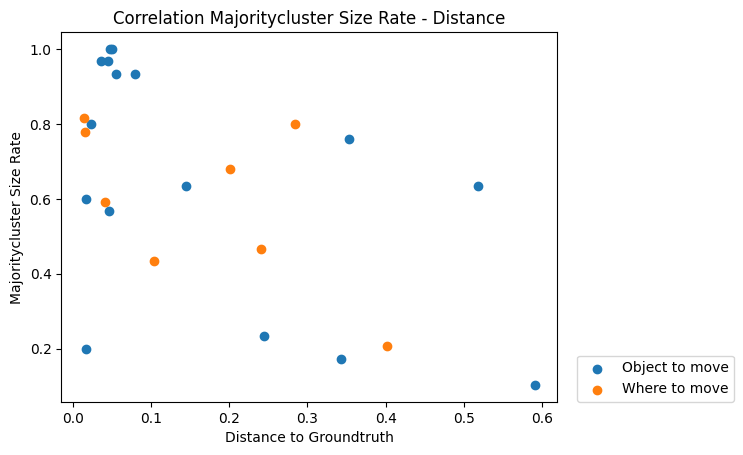

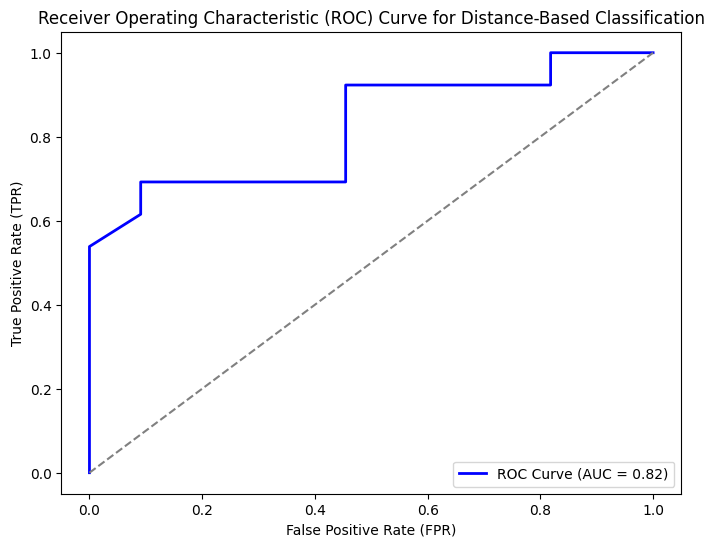

0.7777777777777778


In [7]:
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0] + distances[1], 0.1, majority_size_rates[0] + majority_size_rates[1])
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)

plot_scatter(["Object to move", "Where to move"], majority_size_rates, distances, "Correlation Majoritycluster Size Rate - Distance", "Distance to Groundtruth", "Majoritycluster Size Rate")
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds[best_idx])